(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  2.,  1.,  1.,  2.,  1.,  1.,  4.,  2.,  0.,  5.,  1.,
         4.,  0.,  2.,  5.,  8.,  5., 12.,  6., 10.,  8.,  5., 13.,  6.,
        10., 18., 17., 18., 22., 21., 19., 20., 22., 19., 30., 25., 27.,
        29., 21., 23., 26., 27., 34., 32., 31., 19., 29., 16., 29., 28.,
        19., 17., 33., 22., 13., 24., 16., 20., 11., 14.,  8.,  6.,  4.,
         9.,  9.,  4.,  6.,  7.,  4.,  3.,  5.,  7.,  4.,  2.,  5.,  2.,
         1.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([0.10385866, 0.11094078, 0.11802289, 0.125105  , 0.13218711,
        0.13926922, 0.14635134, 0.15343345, 0.16051556, 0.16759767,
        0.17467979, 0.1817619 , 0.18884401, 0.19592612, 0.20300823,
        0.21009035, 0.21717246, 0.22425457, 0.23133668, 0.23841879,
        0.24550091, 0.25258302, 0.25966513, 0.26674724, 0.27382935,
        0.28091147, 0.28799358, 0.29507569, 0.3021578 , 0.30923992,
        0.31632203, 0.3234

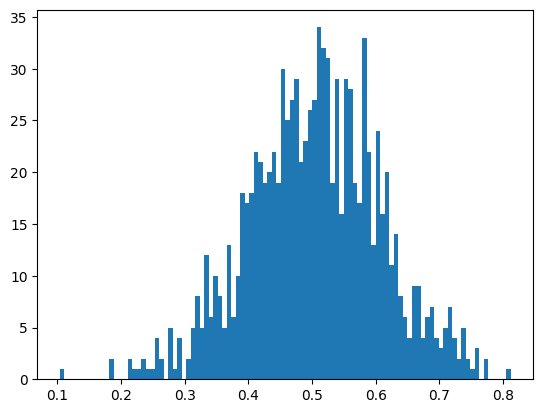

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Number of agents
N = 1000

# Wealth
wealth_arr = abs(np.random.normal(0.5, 0.1, N))
plt.hist(wealth_arr, bins=100)  

(array([76., 50., 55., 47., 42., 53., 53., 40., 34., 42., 32., 28., 26.,
        21., 24., 17., 21., 25., 16., 20., 12., 14., 16., 14., 20., 11.,
         7., 12., 12.,  7., 10.,  7., 15.,  5.,  5.,  8.,  4.,  5.,  7.,
         8.,  4.,  5.,  8.,  1.,  2.,  4.,  0.,  5.,  2.,  4.,  2.,  2.,
         4.,  2.,  4.,  4.,  0.,  7.,  3.,  1.,  0.,  3.,  1.,  0.,  0.,
         0.,  0.,  4.,  2.,  2.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.62762199e-04, 3.24943024e-02, 6.47258427e-02, 9.69573829e-02,
        1.29188923e-01, 1.61420463e-01, 1.93652004e-01, 2.25883544e-01,
        2.58115084e-01, 2.90346624e-01, 3.22578165e-01, 3.54809705e-01,
        3.87041245e-01, 4.19272785e-01, 4.51504326e-01, 4.83735866e-01,
        5.15967406e-01, 5.48198946e-01, 5.80430486e-01, 6.12662027e-01,
        6.44893567e-01, 6.77125107e-01, 7.09356647e-01, 7.41588188e-01,
  

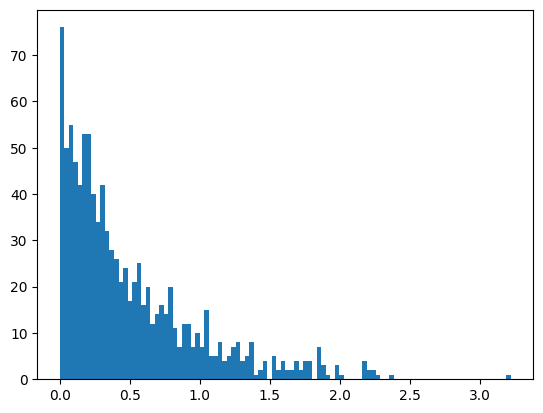

In [2]:
import random
N = 1000
alpha = 1
beta = 0.5

wealth_arr = np.array([random.gammavariate(alpha, beta) for i in range(N)])
plt.hist(wealth_arr, bins=100)

In [3]:
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

gini(wealth_arr)

np.float64(0.5009272043361979)

In [4]:
X = wealth_arr
X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]


(np.float64(0.0), np.float64(0.9999999999999993))

Text(0.5, 1.0, 'Lorenz curve')

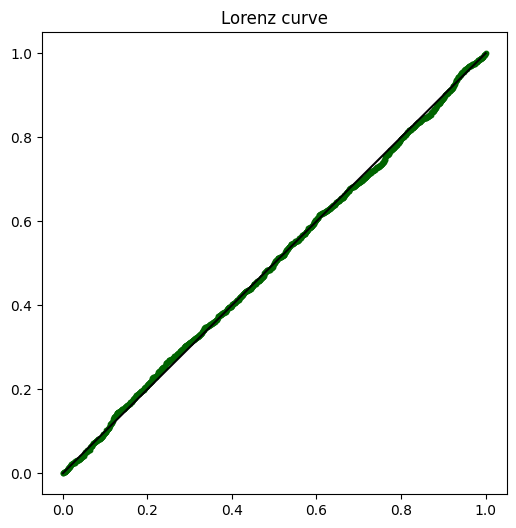

In [5]:
fig, ax = plt.subplots(figsize=[6,6])

ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='darkgreen', s=10)
ax.plot([0,1], [0,1], color='k')
ax.set_title('Lorenz curve')
 

In [6]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class PotentialCriminal(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = model.wealth_arr[unique_id]
        self.criminal = False
        self.wealth = model.wealth_arr[unique_id]
        
    def step(self):
        #if self.criminal:  
        #    return

        other_agent = self.random.choice(self.model.schedule.agents)

        if other_agent.wealth - self.wealth > self.model.deterrence:
            self.criminal = True

            stolen_amount = self.random.random() * other_agent.wealth
            self.wealth += stolen_amount 
            other_agent.wealth -= stolen_amount
        
        return

def get_crime_rate(model):
    agent_out = [agent.criminal for agent in model.schedule.agents]
    return sum(agent_out)/model.num_agents
    

class CrimeModel(Model):
    def __init__(self, N, deterrence, wealth_arr):
        self.num_agents = N
        self.deterrence = deterrence
        self.wealth_arr = wealth_arr
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Crime rate": get_crime_rate},
            agent_reporters={"Criminal": "criminal", "Wealth": "wealth"}
        )
        
        for i in range(self.num_agents):
            a = PotentialCriminal(i, self)
            self.schedule.add(a)
    
    def crime_rate(self):
        return sum([a.criminal for a in self.schedule.agents])/self.num_agents
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [7]:
model = CrimeModel(N, 0.8, wealth_arr)

while model.schedule.steps < 100:
    model.step()


C:\Users\nxg05271\AppData\Local\Temp\ipykernel_41544\816711771.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [8]:
model.datacollector.get_agent_vars_dataframe()

Criminal    Wealth
Step AgentID                    
0    0           False  0.625538
     1           False  0.396511
     2           False  0.085835
     3           False  0.464072
     4           False  0.089062
...                ...       ...
99   883         False  0.532911
     632          True  0.685463
     858          True  0.532789
     597          True  0.791261
     234         False  0.607151

[100000 rows x 2 columns]

In [9]:
model.datacollector.get_model_vars_dataframe()

,Crime rate
0,0.000
1,0.088
2,0.175
3,0.225
4,0.271
...,...
95,0.525
96,0.526
97,0.526
98,0.526


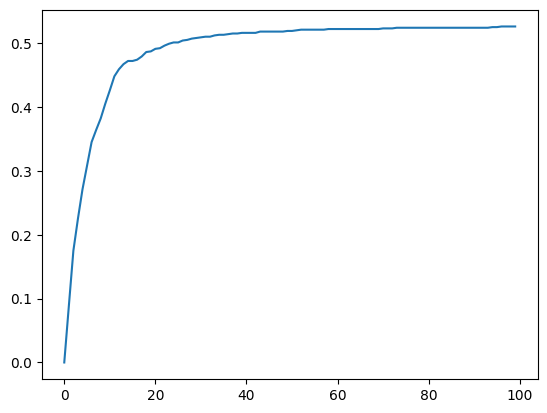

In [10]:
plt.plot(model.datacollector.get_model_vars_dataframe())

In [11]:
df_explo = model.datacollector.get_agent_vars_dataframe().reset_index()
df_explo

,Step,AgentID,Criminal,Wealth
0,0,0,False,0.625538
1,0,1,False,0.396511
2,0,2,False,0.085835
3,0,3,False,0.464072
4,0,4,False,0.089062
...,...,...,...,...
99995,99,883,False,0.532911
99996,99,632,True,0.685463
99997,99,858,True,0.532789
99998,99,597,True,0.791261


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 

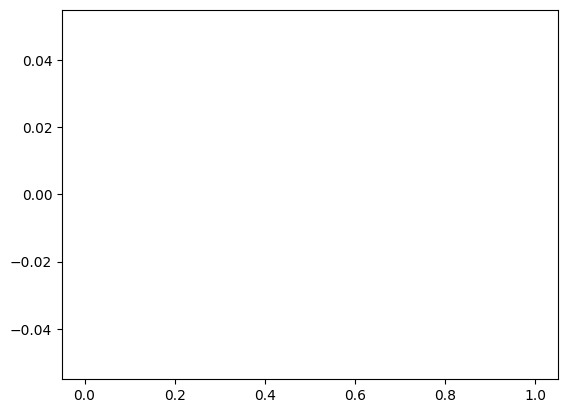

In [12]:
plt.hist(df_explo.loc[df_explo.Step == 999, 'Wealth'], bins=100)